In [18]:
# ==============================
# 📊 Librerías de Manipulación de Datos
# ==============================
import pandas as pd
import numpy as np
import calendar

# ==============================
# 📊 Visualización de Datos
# ==============================
import matplotlib.pyplot as plt
import seaborn as sns


# ==============================
# ⚡ Machine Learning y Modelado
# ==============================
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import RandomizedSearchCV

# ==============================
# 📊 Evaluación del Modelo
# ==============================
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, roc_curve, auc, accuracy_score
)

# ==============================
# 🔍 Interpretabilidad del Modelo (SHAP)
# ==============================
import shap

# ==============================
# ✅ Guardado del Modelo
# ==============================
import pickle
import os

In [19]:
path_data = "/workspaces/AK-EA-GG_ProyectoFinalDS-ML/data/processed/" 

df_train = pd.read_csv(path_data + "clean_train.csv")

In [20]:
# Separar X e y
X_train = df_train.drop(columns=['loan_status'])
y_train = df_train['loan_status']

print("✅ Datos cargados y separados correctamente.")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

✅ Datos cargados y separados correctamente.
X_train shape: (56000, 37)
y_train shape: (56000,)


In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56000 entries, 0 to 55999
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            56000 non-null  float64
 1   term                                 56000 non-null  int64  
 2   int_rate                             56000 non-null  float64
 3   installment                          56000 non-null  float64
 4   sub_grade                            56000 non-null  int64  
 5   emp_length                           52739 non-null  float64
 6   annual_inc                           56000 non-null  float64
 7   dti                                  56000 non-null  float64
 8   pub_rec                              56000 non-null  float64
 9   revol_bal                            56000 non-null  float64
 10  revol_util                           55966 non-null  float64
 11  initial_list_status         

In [22]:
path_data = "/workspaces/AK-EA-GG_ProyectoFinalDS-ML/data/processed/" 

df_test = pd.read_csv(path_data + "clean_test.csv")

In [23]:
# Separar X e y
X_test = df_test.drop(columns=['loan_status'])
y_test = df_test['loan_status']

print("✅ Datos cargados y separados correctamente.")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

✅ Datos cargados y separados correctamente.
X_test shape: (14000, 37)
y_test shape: (14000,)


In [24]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            14000 non-null  float64
 1   term                                 14000 non-null  int64  
 2   int_rate                             14000 non-null  float64
 3   installment                          14000 non-null  float64
 4   sub_grade                            14000 non-null  int64  
 5   emp_length                           13145 non-null  float64
 6   annual_inc                           14000 non-null  float64
 7   dti                                  14000 non-null  float64
 8   pub_rec                              14000 non-null  float64
 9   revol_bal                            14000 non-null  float64
 10  revol_util                           13991 non-null  float64
 11  initial_list_status         

In [25]:
# Instanciar el modelo de XGBoost
xgb_model = XGBClassifier(
    objective='binary:logistic', # Clasificación binaria
    eval_metric='auc',       # Métrica de evaluación
    random_state=42,             # Reproducibilidad
)

In [26]:
# Entrenar el modelo
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

Threshold óptimo: 0.30000000000000004


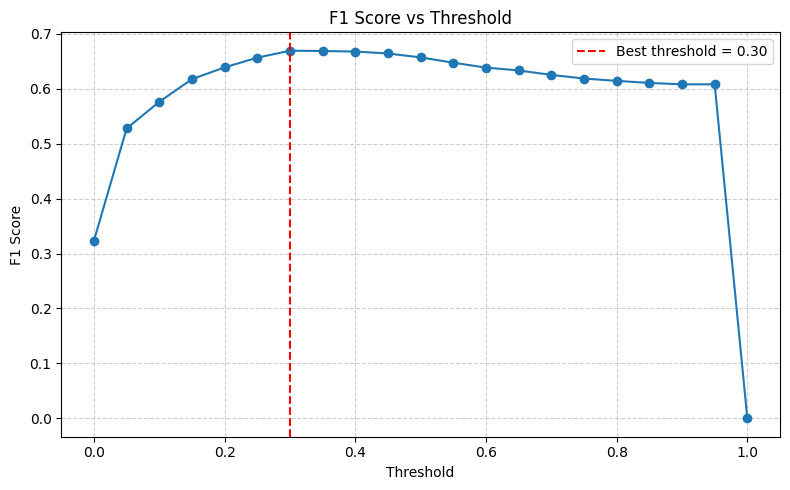

In [27]:
# Obtener las probabilidades del modelo (probabilidad de la clase positiva)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# Definir lista de thresholds
thresholds = np.arange(0.0, 1.05, 0.05)
f1_scores = []

# Probar cada threshold y calcular F1-Score
for threshold in thresholds:
    y_pred = (y_prob >= threshold).astype(int)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

# Seleccionar el threshold óptimo
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Threshold óptimo: {optimal_threshold}")

# Graficar F1-Score vs Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o')
plt.axvline(x=optimal_threshold, color='red', linestyle='--', label=f"Best threshold = {optimal_threshold:.2f}")
plt.title('F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
# Predecir con el threshold óptimo
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

# Calcular métricas
precision = precision_score(y_test, y_pred_optimal)
recall = recall_score(y_test, y_pred_optimal)
f1 = f1_score(y_test, y_pred_optimal)
roc_auc = roc_auc_score(y_test, y_prob)
accuracy = accuracy_score(y_test, y_pred_optimal)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {roc_auc:.4f}")
print(f"Accuracy score: {accuracy:.4f}")

Precision: 0.6367
Recall: 0.7053
F1-Score: 0.6692
AUC: 0.9192
Accuracy score: 0.8655


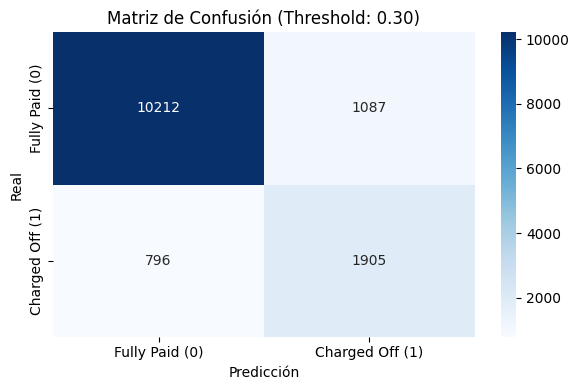

In [29]:
# Calcular la matriz de confusión con el threshold óptimo
y_pred_opt = (y_prob >= optimal_threshold).astype(int)
cm = confusion_matrix(y_test, y_pred_opt)

# Visualizar la matriz de confusión con Seaborn
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fully Paid (0)', 'Charged Off (1)'],
            yticklabels=['Fully Paid (0)', 'Charged Off (1)'])
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title(f'Matriz de Confusión (Threshold: {optimal_threshold:.2f})')
plt.tight_layout()
plt.show()

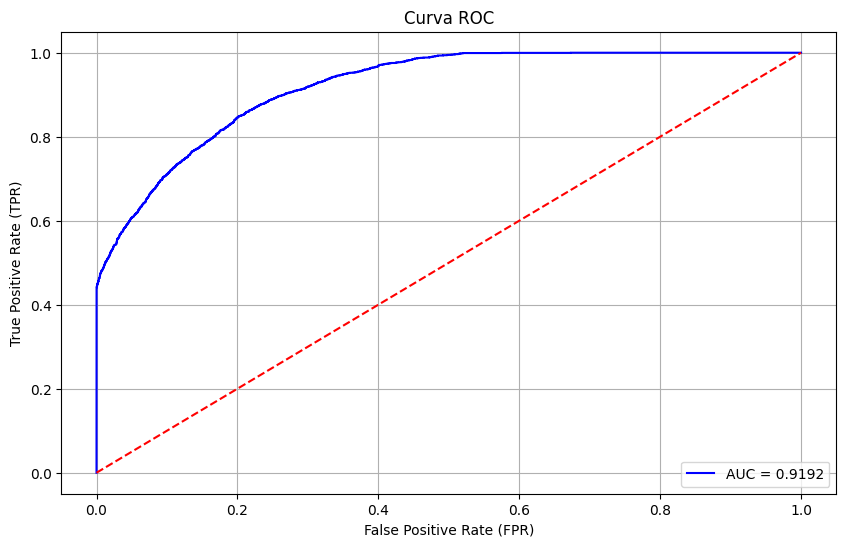

In [30]:
# Calcular FPR, TPR y thresholds para la curva ROC
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'r--')
plt.title("Curva ROC")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.legend(loc="lower right")
plt.grid()
plt.show()

 98%|===================| 13707/14000 [00:31<00:00]        

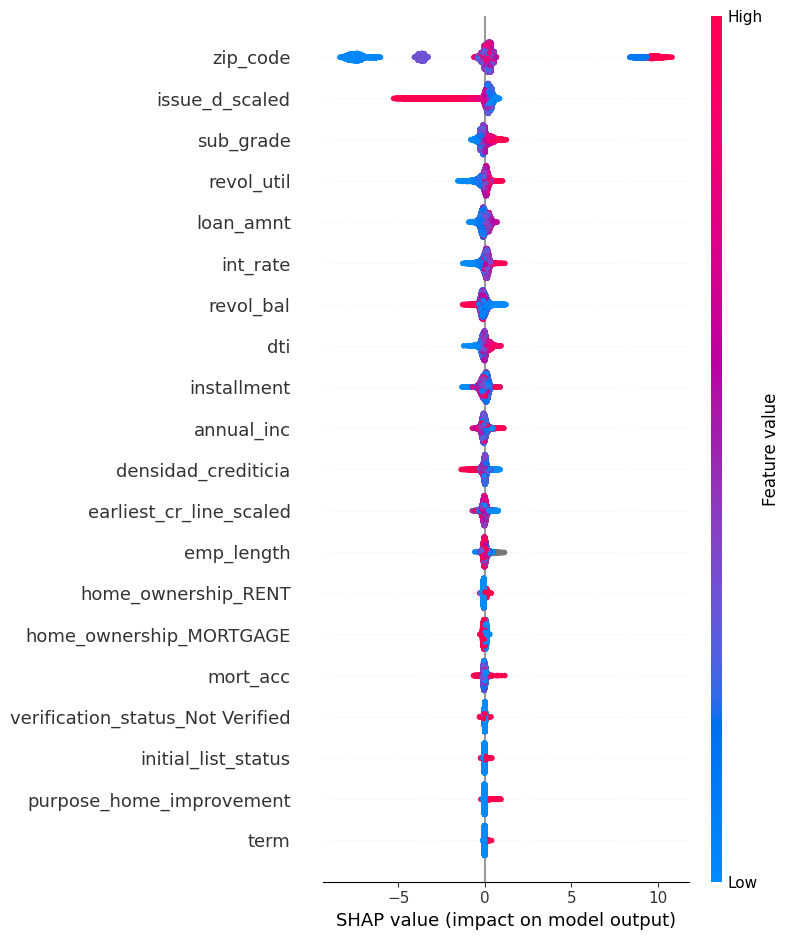

In [31]:
# Crear el Explainer de SHAP para XGBoost
explainer = shap.Explainer(xgb_model, X_train)

# Calcular valores SHAP para el conjunto de prueba
shap_values = explainer(X_test)

# Resumen global de valores SHAP
shap.summary_plot(shap_values, X_test)

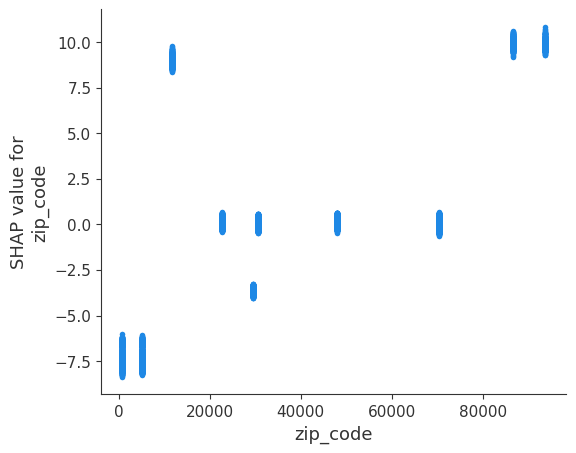

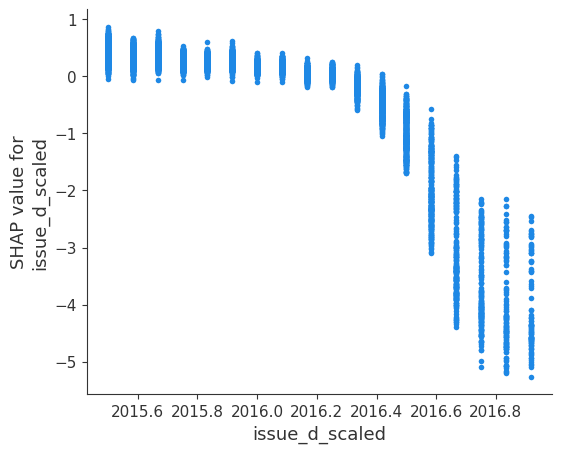

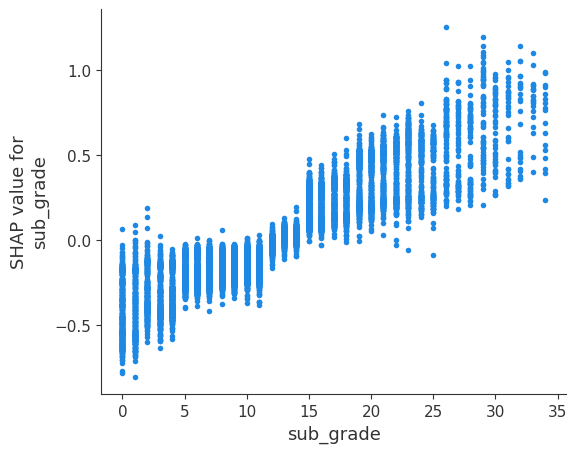

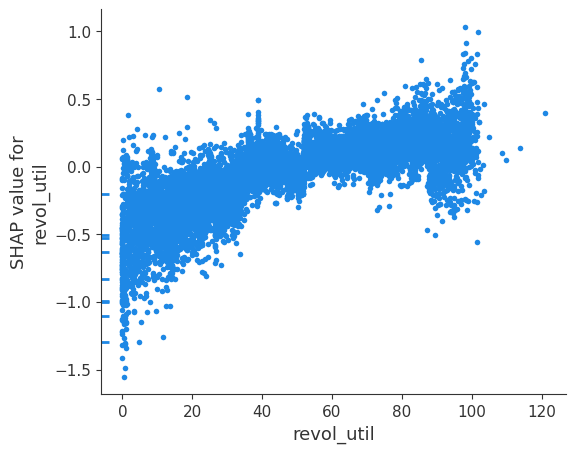

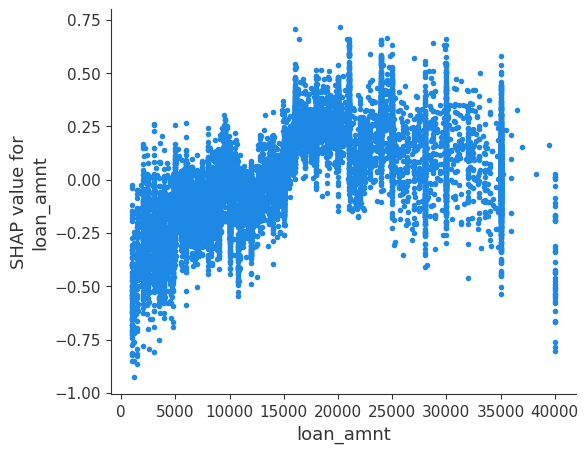

In [32]:
# Verificar que X_test está en formato DataFrame float
X_test_float = X_test.astype(float)

# Convertir valores SHAP al formato esperado (array)
shap_values_array = shap_values.values if hasattr(shap_values, "values") else shap_values

# Lista de variables clave para análisis
variables_clave = ["zip_code", "issue_d_scaled", "sub_grade", "revol_util", "loan_amnt"]

# Crear los dependence plots correctamente
for variable in variables_clave:
    shap.dependence_plot(variable, shap_values_array, X_test_float, interaction_index=None)

<Figure size 1000x800 with 0 Axes>

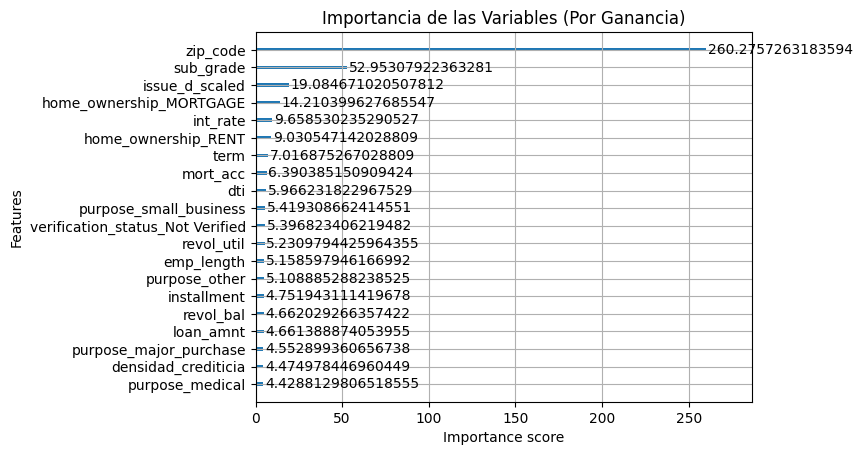

In [33]:
# Visualización de las variables más importantes del modelo (por Ganancia)
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, importance_type='gain', max_num_features=20)
plt.title("Importancia de las Variables (Por Ganancia)")
plt.show()

In [34]:
# Definir la ruta donde se guardarán los modelos
model_dir = '/workspaces/AK-EA-GG_ProyectoFinalDS-ML/models'

# Guardar xgb_model
xgb_path = os.path.join(model_dir, 'xgb_model.pkl')

with open(xgb_path, 'wb') as model_file:
    pickle.dump((xgb_model, optimal_threshold), model_file)

print(f"Modelo xgb_model guardado en: {xgb_path}")

Modelo xgb_model guardado en: /workspaces/AK-EA-GG_ProyectoFinalDS-ML/models/xgb_model.pkl
